# Doubles

Created by Kidror

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-doubles.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

season = 14
df = df[df['season'] == season]
len(df)

5164

In [2]:
dfc = df.copy()
for exclude_mod in ["O_NO", "ON_FIRE", "OVERPERFORMING", "UNDERPERFORMING", "GROWTH", "HIGH_PRESSURE", "SINKING_SHIP", "TRAVELING", "CHUNKY", "SMOOTH", "SHELLED"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']
pitcher_params = ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

dfc = dfc[dfc["batter_multiplier"] == 1]
dfc = dfc[dfc["pitcher_multiplier"] == 1]

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["musc_vibes"] = dfc["batter_musclitude"] * (1 + 0.2*dfc["batter_vibes"])
dfc["ind_vibes"] = dfc["batter_indulgence"] * (1 + 0.2*dfc["batter_vibes"])
dfc["gf_vibes"] = dfc["batter_ground_friction"] * (1 + 0.2*dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["unthwack_vibes"] = dfc["pitcher_unthwackability"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["ruth_vibes"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["shakes_vibes"] = dfc["pitcher_shakespearianism"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["supp_vibes"] = dfc["pitcher_suppression"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["chase_vibes"] = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
dfc["cold_vibes"] = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["omni_vibes"] = dfc["pitcher_omniscience"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["invpath"] = 1 - dfc["batter_patheticism"] * (1 + 0.2*dfc["batter_vibes"])
dfc["park_park"] = dfc["ballpark_forwardness"] + dfc["ballpark_viscosity"] - dfc["ballpark_ominousness"]

X = dfc[["roll",'musc_vibes', "opw_vibes", "chase_vibes", "ballpark_forwardness", "ballpark_viscosity", "ballpark_ominousness", "ballpark_grandiosity", "ballpark_obtuseness", "ballpark_inconvenience", "ballpark_elongation"]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=10000, max_iter=10000, tol=1e-5).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[2110,    0],
       [   0,  615]])

In [4]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

2110
615


In [5]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'),
 (-0.19669777222031415, 'musc_vibes'),
 (-0.08845459306462884, 'ballpark_forwardness'),
 (0.07572239691191034, 'chase_vibes'),
 (0.04824750641415585, 'ballpark_ominousness'),
 (0.03655461926037923, 'opw_vibes'),
 (0.03168978528625005, 'ballpark_elongation'),
 (0.0216441267926803, 'ballpark_obtuseness'),
 (0.014407804239591825, 'ballpark_inconvenience'),
 (0.0077262522858152615, 'ballpark_viscosity'),
 (0.0051221377804251495, 'ballpark_grandiosity')]

In [6]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.17918941])

In [7]:
opw = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
grand = dfc["ballpark_grandiosity"]
vis = dfc["ballpark_viscosity"]
fwd = dfc["ballpark_forwardness"]
omi = dfc["ballpark_ominousness"]
elong = dfc["ballpark_elongation"]
musc = dfc["batter_musclitude"] * (1 + 0.2*dfc["batter_vibes"])
sup = dfc["pitcher_suppression"] * (1 + 0.2*dfc["pitcher_vibes"])
omni = dfc["pitcher_omniscience"] * (1 + 0.2*dfc["pitcher_vibes"])
obtuse = dfc["ballpark_obtuseness"]
incon = dfc["ballpark_inconvenience"]
chase = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
cold = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])

# Musc, OPW, FWD, Grand, OMI, Probably Fielder Chasiness
# S12 & 13- 0.17 + 0.2*musc - 0.1*chase - 0.04*opw
# S14 0.1575 + 0.2*musc - 0.09*chase - 0.04*opw - 0.0125*vis + 0.0275*fwd + 0.006*omi

dfc["threshold"] = 0.1565 + 0.2*musc - 0.1*chase - 0.04*opw - 0.0125*vis + 0.0275*fwd + 0.0065*omi

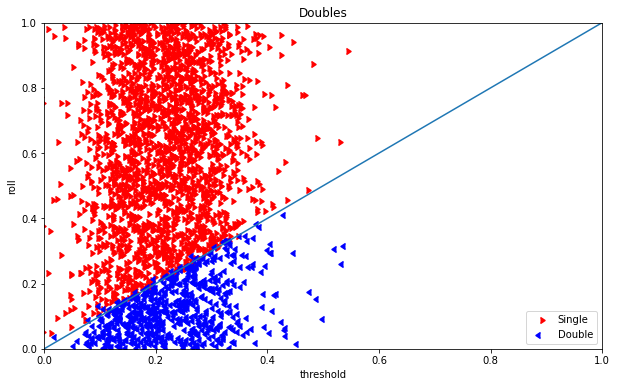

In [8]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Single", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Double", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Doubles")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.legend()

,offset,weather,event_type,batter_ground_friction,pitcher_overpowerment,roll,threshold,fielder_name,fielder_chasiness,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
9496,-0.004220,Weather.SALMON,Hit1,0.349947,0.776169,0.244520,0.248739,---atc- --le--e,0.508577,Wichita Toaster,Xandra Pancakes,NaN,NaN,NaN,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,47,fcc62ae2-e9ea-41af-80a5-fcfec162f7e5,133
7856,-0.003328,Weather.COFFEE_2,Hit1,0.932341,0.289862,0.261517,0.264845,Randy Castillo,0.079389,Hahn Fox,Dunlap Figueroa,NaN,NaN,BASE_INSTINCTS,FIREPROOF;SEALANT;AMBUSH,34,7fbbba5b-74d8-4651-8e0d-4e76a3c71588,227
11767,-0.000064,Weather.FLOODING,Hit1,0.998666,0.229340,0.244993,0.245058,Summers Preston,0.065750,Baby Triumphant,Mags Banananana,REVERBERATING,WANDERER,PARTY_TIME,NaN,91,54180bbb-4bb1-428c-b2ea-570de8a1d0d3,85
10335,0.000211,Weather.COFFEE_3S,Hit2,0.765979,0.226437,0.164799,0.164588,Baby Triumphant,0.570087,Ril-y Fir-w---,Agan Harrison,SCATTERED,NaN,LIFE_OF_PARTY;ELECTRIC,NaN,79,2537d176-b250-492e-9912-f783ba61a704,354
11207,0.000211,Weather.FLOODING,Hit2,0.421326,0.435854,0.101631,0.101420,Baby Doyle,0.836844,Matteo Triumphant,Kathy Mathews,NaN,ALTERNATE,FIREPROOF;SEALANT;AMBUSH,NaN,86,dc38fee5-62fd-42f2-a6c1-6aa73efd0ece,264
11169,0.000715,Weather.FLOODING,Hit2,0.600793,0.435854,0.189331,0.188616,D---in -o-c-y-a,0.644453,Paula Turnip,Kathy Mathews,COFFEE_RALLY,ALTERNATE,FIREPROOF;SEALANT;AMBUSH,NaN,86,dc38fee5-62fd-42f2-a6c1-6aa73efd0ece,184
10029,0.001076,Weather.FLOODING,Hit2,1.291212,1.132860,0.199683,0.198607,Freemium Seraph,0.369826,Basilio Fig,Alejandro Leaf,FIRE_EATER,HONEY_ROASTED;WANDERER,SUN_KISSED;SUN2_PAYOUTS,POPCORN_PAYOUTS,77,76e9a23c-7888-4f0d-b104-42eb708bfeb1,172
10350,0.001811,Weather.SALMON,Hit2,0.718558,0.830381,0.221736,0.219925,Thomas Dracaena,0.711973,Marquez Clark,Fynn Doyle,REPEATING,ALTERNATE,MIDDLING,BIRD_SEED,80,5a42ce29-a2c4-4cf0-aa98-15247deafea7,48
11387,0.002247,Weather.PEANUTS,Hit2,0.802250,0.668787,0.327948,0.325701,Silvaire Semiquaver,0.354993,Kaz Fiasco,Nandy Slumps,NaN,NaN,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,POPCORN_PAYOUTS,88,1da49bae-1477-4a94-8d44-a6c8b85cf1d7,51
9889,0.003153,Weather.SUN_2,Hit2,0.700174,1.089808,0.151113,0.147960,Loubert Ji-Eun,0.834061,Roscoe Sundae,Rivers Rosa,COFFEE_RALLY,NaN,NaN,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,76,4cc013d0-9e00-4778-90f5-c704ed5d86a7,158


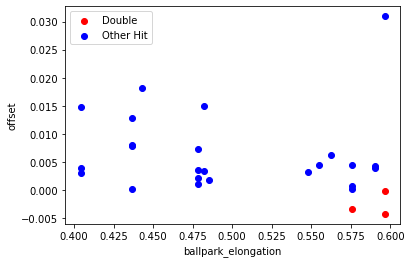

In [9]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_elongation"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Double")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Other Hit")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "weather", "event_type", "batter_ground_friction", "pitcher_overpowerment",
       "roll", "threshold",
       "fielder_name", "fielder_chasiness",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


In [10]:
print(dfc[dfc["passed"]]["roll"].min())
print(dfc[~dfc["passed"]]["roll"].max())

0.0001018809746822
0.9998606032255044
